# Introduction

The increasing abundance and complexity of biological data often requires programatic approaches for their analysis that allow for the rapid development of custom yet efficient, well-tested and reproducible analysis pipelines. 

Traditional approaches (e.g., bash command/perl pipelines), that suffer from low readability, maintainability and reproducibility,
are increasingly superseded by complex, containerized (e.g., Singularity) analysis pipelines that combine specialized bioinformatics tools 
with custom scripts developed in higher programming languages such as *Python*, *R* or *Rust*.

Despite not being the fastest option, *Python* is a [popular choice by analysts](https://github.blog/2023-03-02-why-python-keeps-growing-explained/), mainly due to the large number of available (bioinformatics) libraries, its simple and well-documented syntax and its broad utility in the emerging data science field.

For this reason an increasing number of python APIs for the handling of genomics data are being developed. 
While some are mainly wrappers around well-established bioinformatics tools (e.g., pysam/samtools, pybedtools/BEDTools or cyvcf2/htslib) others are builing on efficient data wrangling/analysis libraries such as *pandas* or *numpy* (e.g., bioframe/pandas, pyranges/pandas, bionumpy/numpy).

Here, we present *pygenlib*, a python utilities library for handling genomics data with a focus on transcriptomics and 

In a [second notebook](RelatedWork_performance.ipynb), we compare pygenlib to a number of related APIs with regard to provided features and performance. We additionally demonstrate some common analysis pitfalls that we tried to address in the design of our library.

We provide a set of tutorials for demonstrating pygenlib in realistic usage scenarios:
* [Tutorial: Read mismatch analysis](Tutorial_mismatch_analysis.ipynb)
* [Tutorial: Comparison of gene annotation sets](Tutorial_compare_annotation_sets.ipynb)
* [Tutorial: shRNA analysis](Tutorial_shRNA_analysis.ipynb)
* [Tutorial: Transcriptome analysis](Tutorial_transcriptome_annotation.ipynb)

Finally, we showcase how the combination of (the strengths of) multiple genomics libraries leads to an overall benefit in multiple tutorials:
* [Tutorial: CTCF analysis with pygenlib and bioframe](Tutorial_CTCF_analysis.ipynb)
* [Tutorial: Expression analysis with pygenlib and genemunge](Tutorial_expression_analysis.ipynb)


## Test datasets

This notebook as well as pygenlib's testing suite use various test data files that can be created by running the pygenlib testdata python script. This class contains a `test_resources` dict that describes the various test resources and their origin. Once downloaded, test data resources can be accessed via `get_resource(<resource_id>)`.

The tutorial notebooks contain respective cells for (temporarily) downloading larger test files that are needed to demonstrate pygenlib under realistic conditions. 

Note that pygenlib expects all referenced genomics datasets to be compressed and indexed (e.g., BED files must be bgzipped and accompanied by a tabix index; SAM files must be in binary (BAM) format and accompanied by a BAM (bai) index). This ensures that these datasets are coordinate-sorted and can be efficiently sliced.

In [1]:
# set path and load pygenlib
import os, pathlib, platform
PYGENLIB_SRC=pathlib.Path('/Users/niko/projects/pygenlib/') 
os.chdir(PYGENLIB_SRC)
# install libraries. Recommended to run in a venv here!
#!{sys.executable} -m pip install -r requirements.txt 
display(f"Running pygenlib on python {platform.python_version()}. Using pygenlib code from {PYGENLIB_SRC}")
# load pygenlib
import pygenlib as pg
from pygenlib import gi, SEP, display_textarea
# load other libs
import biotite.sequence as seq
from Bio.Align import PairwiseAligner
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import pysam
import numpy as np
import pprint
import pybedtools 
import bioframe
import tempfile
import pytest
import dataclasses
import random

'Running pygenlib on python 3.10.4. Using pygenlib code from /Users/niko/projects/pygenlib'

# Pygenlib

Pygenlib is a python utilities library for handling genomics data with a focus on transcriptomics. 
It is roughly structured into the following modules:

- [iterators](#Iterators): efficient iteration over subregions of large-scaled genomics datasets based on the pysam library. Iterators keep track of the genomic region of the
  yielded data enabling their efficient integration with other genomics data
- [transcriptome](#Transcriptome): python classes for modeling gene/transcript annotations and many useful querying/annotation methods.
- [utils](#Utility-functions): general (low-level) utility functions for working with genomics datasets.


Pygenlib implements a transcriptome data model that preserved parent/child relationships between features (e.g., transcripts and introns) and a secure way for annotating such features by structuring them into immutable genomic locations (that can, e.g., safely be used in lookup tables) and mutatble, arbitrary annotations. 


Transcriptomics analyses require the integration of various biological data sources (e.g., gene/transcript annotations, sequence alignment data, genomic scores, etc.) which is why pygenlib implement variour genomic iterators on top of existing python implementations (pysam, bioframe, pybedtools).

This ipython notebook demonstrates some of pygenlib's functionality and API using simple and complex access examples. Please also refer to pygenlib's test classes for further API examples.

Note that this notebook uses various genomics data test files that can be accessed via the `pygenlib.testdata.get_resource('<test_resource_id'>` method. See the testdata.py class for details how these files were created.


## Genomic intervals
At the heart of pygenlib is its representation of genomic regions (intervals), represented by the  *genomic intervals* (gi) class in pygenlib:
- Genomic intervals (gi) in pygenlib are inclusive and 1-based.
  - This model was chosen to make interpretation of GIs straightforward: the start and end coordinates represent the first/last included nucleotide as also seen in a genome browser (such as IGV)
- GIs are implemented as frozen (pseudo immutable) dataclasses 
  - GIs can theredore be safely used as keys in a dict.
- GIs can be instantiated by passing chrom/start/stop coordinates or can be parsed form a string.
- GIs can be stranded. Unstranded intervals are represented by setting strand to None (default) 
- Using None for each component of the coordinates is allowed to represent unbounded intervals. Examples:
  - gi('chr1') refers to the whole chromosome
  - gi('chr1', 100000) refers to the section of chromosome 1 from (and including) positon 100k on.
  - gi(start=100, end=200) refers to positions 100-200 (inclusive) on any chromosome 
- Points are represented by GIs with same start and end coordinate.
  - Thus are intervals that represent exactly one nucleotide.
- Empty intervals are represented by GIs with start>end coordinates (experimental).
  - Several real genomics datasets contain (wrongly annotated) empty intervals that can easily be filtered bz pygenlib.

GIs represent genomic intervals on a chromosome of some reference genome. Chromosome order in such a genome is represented by *ReferenceDict*s (which extend regular python dicts).
- ReferenceDicts can be used to properly sort genomic intervals (see example below)
- ReferenceDicts keep track of the available chromosomes and their length and are typically directly derived from genomic data (index) files
- ReferenceDicts are used in pygenlib to check for compatibility of different genomic datasets


More documentation can be accessed via
`help(gi)`

In [9]:
# create a list of genomic intervals
locs=[gi('chr2', 1, 100), # chr2:1-100, unstranded
      gi.from_str('chr1:5-500 (+)'),  # parsed from string, strand='+'
      gi.from_str('chr3:50-120 (-)'), 
      gi.from_str('chr1:10-20 (-)'), 
      gi(None, None, 1000, '-'), # chromosome and start unbound, end=1000, strand='-'
      gi(None, 10, 1000, '-')] # chromosome unbound
display('Sorted by start coordinate but order of chromosomes is undefined:', sorted(locs), SEP)

# To sort also by chromosome, you can use a reference dict which defined the chromosome order:
refdict=pg.ReferenceDict({'chr1':None, 'chr2':None, 'chr3':None}, 'test', None)
display(refdict, SEP)
# And then call the gi.sort(...) method which is basically returning 
# sorted(locs, key=lambda x: (refdict.index(x.chromosome), x))
display('Properly sorted list:', gi.sort(locs, refdict))
# Note that typically you don't need to do this as pygenlib deals with bgzipped+tabixed files that are always 
# sorted and automatically derived reference dicts from the index. For manually created intervals or interval 
# sets derived via other sources that allow access to (potentially) unsorted files (e.g., pygenlib), you can 
# use gi.sort() 

# Unbounded intervals (chromosome=None) will always be at the beginning of the list. 
# Generally, the order of intervals from different groups (chromosomes) is left undefined.
display(f"Is the greater-than comparison chr2:1-1>chr1:1-1 defined? {gi('chr2', 1, 1) > gi('chr1', 1, 1)}", SEP)

# All intervals with start>end coordinate is considered 'empty'; internally, its coordinates are set to [0, maxint].
empty_interval=gi('1',2,1)

# Empty intervals have zero length
display(f"The length of empty interval is {len(empty_interval)}, the length of unbounded intervals is defined as 2^31-1 (assuming int32): {len(empty_interval)}", SEP)
display(f"Empty intervals do not overlap/do not envelop any interval including itself (overlap={empty_interval.overlaps(empty_interval)})")
display(f"Empty intervals are considered equal to any other empty interval on the same chromosome: ({empty_interval==gi('1',20,19)})...")
display(f"...but different from empty intervals on other chromosomes to not break chromsome order ({empty_interval==gi('2',20,19)})", SEP)

'Sorted by start coordinate but order of chromosomes is undefined:'

[None:0-1000 (-),
 chr2:1-100,
 chr1:5-500 (+),
 chr3:50-120 (-),
 chr1:10-20 (-),
 None:10-1000 (-)]

---

RefSet (size: 3): dict_keys(['chr1', 'chr2', 'chr3']), dict_values([None, None, None]) name: test 

---

'Properly sorted list:'

[None:0-1000 (-),
 None:10-1000 (-),
 chr1:5-500 (+),
 chr1:10-20 (-),
 chr2:1-100,
 chr3:50-120 (-)]

'Is the greater-than comparison chr2:1-1>chr1:1-1 defined? None'

---

'The length of empty interval is 0, the length of unbounded intervals is defined as 2^31-1 (assuming int32): 0'

---

'Empty intervals do not overlap/do not envelop any interval including itself (overlap=False)'

'Empty intervals are considered equal to any other empty interval on the same chromosome: (True)...'

'...but different from empty intervals on other chromosomes to not break chromsome order (False)'

---

## Iterators

_pygenlib_ implements several *LocationIterator*s for efficient iteration over (parts of) genomics datasets while keeping track of the [genomic interval](#Genomic-intervals) each yielded item refers to. Most implemented iterators are based on respective [pysam](https://pysam.readthedocs.io/en/latest/api.html) classes but extend them with different filtering/access methods and add sanity checks to avoid common errors when combining different genomics datasets.
The primary goal of LocationIterators is to support the synchronization/integration of different genomics datasets. LocationIterators also support chunked I/O where feasible and not supported by the underlying (pysam) implementation.

LocationIterators can iterate whole datasets or specific sub-region (e.g., a certain chromosome or genomic region). Yielded data items are sorted by respective [genomic intervals](#Genomic-intervals) where the order of chromosomes is defined by a [ReferenceDict](#Genomic-intervals) that is derived directly from the iterated dataset (e.g., by querying it's tabix index). When multiple LocationIterators are integrated (e.g., by an AnnotationIterator), their ReferenceDicts are checked for compatibility.

Sometimes, genomics datasets from different providers used differing chromosome ids to refer to the same chromosomes which hinders their integration. 
Location iterators support chromosome aliasing as a quick solution for this: users can provide aliasing functions (e.g., for adding/removing 'chr' prefixes from 
chromosome ids) to dynamically change chromosome ids while keeping the underlying data files untouched.

Implemented LocationIterators include:
* [MemoryIterator](#MemoryIterator): iterates over genomic interval sets stored in various default python data structures (list, dicts).
* [FastaIterator](#FastaIterator): iterates FASTA files per position or genomic window (e.g., Tiling/sliding windows).
* [FastqIterator](#FastqIterator): iterates FASTQ entries (NOTE that this is no LocationIterator)
* [GFF3Iterator](#GFF3Iterator): iterates GTF/GFF3 files and parses annotation data. Used for the [Transcriptome](#transcriptome) implementation
* [ReadIterator](#ReadIterator): iterates SAM/BAM files and implements various filter options. 
* [FastPileupIterator](#FastPileupIterator): a faster alternative to pysam's pileup method
* [VcfIterator](#AnnotationIterator): iterates VCF files and can filter for samples
* [AnnotationIterator](#AnnotationIterator): annotates the items from one LocationIterator with items from others

and many more (see API documentation).
The following sections showcase some of the implemented iterators:

### MemoryIterator
Iterates over genomic interval sets stored in various default python data structures (list, dicts).

In [12]:
# Here we iterate over a list. Intervals will be sorted and the index (int the original input list) will be reported in the data section.
display(pg.MemoryIterator([gi.from_str('chr1:100-1000'), 
                        gi.from_str('chr1:100-1000'), # duplicate interval that will be reported
                        gi.from_str('chr1:10-100'), 
                        gi.from_str('chr2:12-64')]).to_list(), SEP )
# Here we iterate over a dict. The mapped values will be reported in the data section.
display(pg.MemoryIterator({gi.from_str('chr1:100-1000'): 'a1', 
                        gi.from_str('chr1:100-1000'): 'a2', # This will replace 'a1' in the dict!
                        gi.from_str('chr1:10-100'): 'b', 
                        gi.from_str('chr2:12-64'): 'c'}).to_list(), SEP )
# Here we iterate over a reverse dict. This allows for iterating duplicate intervals with different IDs.
display(pg.MemoryIterator({'a1': gi.from_str('chr1:100-1000'), 
                        'a2': gi.from_str('chr1:100-1000'),
                        'b':  gi.from_str('chr1:10-100'), 
                        'c':  gi.from_str('chr2:12-64')}).to_list() )

[Item(location=chr1:10-100, data=2),
 Item(location=chr1:100-1000, data=0),
 Item(location=chr1:100-1000, data=1),
 Item(location=chr2:12-64, data=3)]

---

[Item(location=chr1:10-100, data='b'),
 Item(location=chr1:100-1000, data='a2'),
 Item(location=chr2:12-64, data='c')]

---

[Item(location=chr1:10-100, data='b'),
 Item(location=chr1:100-1000, data='a1'),
 Item(location=chr1:100-1000, data='a2'),
 Item(location=chr2:12-64, data='c')]

### FastaIterator
Iterates over a FASTA file but enables also tiling/sliding windows and padding.

In [13]:
# get 5mer sliding windows (step size 2) with padding from a GRCh38 chr7 region around ACTB; 
# show first and last 5 results.
# item.data returns the data item returned by this iterator (here: a string containing the kmer)
# item.location (not used in this example) is a GI describing the genomic location of this sequence
with pg.FastaIterator(pg.get_resource('ACTB+SOX2_genome'), # a sliced version of the reference genome.
                      region=gi('chr7', 0, 1000), # iterated region
                      width=5, # report 5-mers
                      step=2,  # step size: 2
                      padding=True) as it:
    kmers = [kmer for loc,kmer in it] # take consumes all items from the iterator
display(f"{kmers[:5]}...{kmers[-5:]}")

"['NNTTG', 'TTGTG', 'GTGCC', 'GCCAT', 'CATTA']...['ATCAT', 'CATTC', 'TTCAA', 'CAAAN', 'AANNN']"

### FastqIterator
Iterates over a FASTQ file and returns named tuples (name seq qual) containing read names, sequence 
and quality strings. Note that this is no Location iterator as unaligned reads have no (known) genomic location.

In [18]:
# iterate over PE reads in two FASTQ files and display their read names and sequence lengths.
# We use pythons zip() method to access tuples of reads
for r1,r2 in zip(pg.FastqIterator(pg.get_resource('small_PE_fastq1')), 
                 pg.FastqIterator(pg.get_resource('small_PE_fastq2'))):
    display(f"{r1.name}, {r2.name}")
    display(f"len r1: {len(r1.seq)}, len r2: {len(r2.seq)}")

'@M01558:94:000000000-B4PB4:1:1101:16988:1392 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:16988:1392 2:N:0:20'

'len r1: 251, len r2: 250'

'@M01558:94:000000000-B4PB4:1:1101:16905:1394 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:16905:1394 2:N:0:20'

'len r1: 251, len r2: 251'

'@M01558:94:000000000-B4PB4:1:1101:16922:1403 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:16922:1403 2:N:0:20'

'len r1: 251, len r2: 250'

'@M01558:94:000000000-B4PB4:1:1101:15249:1404 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:15249:1404 2:N:0:20'

'len r1: 251, len r2: 250'

'@M01558:94:000000000-B4PB4:1:1101:15251:1423 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:15251:1423 2:N:0:20'

'len r1: 251, len r2: 250'

### VCFIterator
Iterates over VCF files and yields VcfRecords that wrap (and partially parse) pysam VcfProxy objects.
It provides convenience methods to access and filter contained samples and enables filtering based on called 
genotype, number of calls across samples or zygosity. Additional format columns are automatically parsed and accessible via dot-notation. 

In [37]:
stats=Counter()
with pg.VcfIterator(pg.get_resource('dmel_multisample_vcf')) as it:
    # show included samples
    display(f'Contained samples: {len(it.allsamples)}, e.g., {it.allsamples[:3]}')
    for loc,vr in it:
        # include only variants that are called (i.e., not './.') in more than half of the samples
        if vr.n_calls/len(vr.GT)>0.5:
            stats[f"{vr.ref}/{vr.alt}"] += 1
display('all variants:', stats, SEP)

# repeat analysis , this time considering 3 samples only
stats=Counter()
with pg.VcfIterator(pg.get_resource('dmel_multisample_vcf'), 
                    samples=['DGRP-738', 'DGRP-859', 'DGRP-59']) as it:
    for loc,vr in it: # this will skip all entries that are uncalled in the 3 samples
        stats[f"{vr.ref}/{vr.alt}"] += 1
display('3 sample variants:', stats, SEP)

# show access to ID column, INFO dict and FORMAT data (per sample!)
with pg.VcfIterator(pg.get_resource('test_vcf')) as it:
    for loc,vr in it: 
        display(f"{vr}, ID: {vr.id}, END: {vr.info.get('END', 'NA')}, CS: {vr.CS}")


"Contained samples: 159, e.g., ['DGRP-738', 'DGRP-859', 'DGRP-59']"

'all variants:'

Counter({'C/T': 3, 'A/G': 2, 'G/T': 1, 'G/A': 1})

---

'3 sample variants:'

Counter({'C/T': 3,
         'T/A': 3,
         'T/C': 2,
         'G/A': 1,
         'C/A': 1,
         'A/G': 1,
         'G/C': 1,
         'C/G': 1})

---

"chr1:100001C><DEL>, ID: TEST-127, END: 100126, CS: {'SAMPLE': 'A'}"

"chr1:200001C><DEL>, ID: TEST-126, END: 200125, CS: {'SAMPLE': 'B'}"

"chr1:300001C><DEL>, ID: TEST-128, END: 300127, CS: {'SAMPLE': 'C'}"

"chr2:1000A>T, ID: None, END: NA, CS: {'SAMPLE': 'D'}"

### GFF3Iterator
Iterates over GFF3 files and yields dicts containing parsed annotation fields. This iterator
is used for building transcriptome features as discussed below.

In [38]:
# Show first two data items from a GFF3 file
pg.display_list(pg.GFF3Iterator(pg.get_resource('gencode_gff')).to_list()[:2])

# iterate whole GFF3 file and collect stats of contained feature_type annotations
display(Counter([item.data['feature_type'] for item in pg.GFF3Iterator(pg.get_resource('gencode_gff'))]))

# iterate transcripts and collect stats of contained transcript_type annotations
display(Counter([item.data.get('transcript_type', 'NA') for item in \
                 pg.GFF3Iterator(pg.get_resource('gencode_gff')) if item.data['feature_type']=='transcript']))

Counter({'exon': 108,
         'transcript': 89,
         'CDS': 60,
         'five_prime_UTR': 33,
         'three_prime_UTR': 20,
         'start_codon': 17,
         'stop_codon': 13,
         'gene': 5})

Counter({'lncRNA': 64,
         'protein_coding': 16,
         'retained_intron': 4,
         'nonsense_mediated_decay': 2,
         'protein_coding_CDS_not_defined': 2,
         'processed_pseudogene': 1})

### ReadIterator
Iterates SAM/BAM files and implements several filter options. Also keeps track of how many reads were filtered for what reason.
Can also yield mismatches wrt. the reference if MD tags are available (can be added, e.g., by [samtools calmd](http://www.htslib.org/doc/samtools-calmd.html) if not added by the mapper itself). See the respective tutorial 
for more information.

In [24]:
# count reads per chromosome in a BAM using different filters
stats={x:Counter() for x in ['all', 'def', 'mq20', 'tag']}
with pg.open_file_obj(pg.get_resource('small_example_bam')) as bam:
    for chrom in tqdm(pg.ReferenceDict.load(bam)):
        with pg.ReadIterator(bam, chrom, flag_filter=0) as it: # all: no filtering
            it.to_list()
            stats['all'].update(it.stats)
        with pg.ReadIterator(bam, chrom) as it: # def: default flag filter (as in IGV)
            it.to_list()
            stats['def'].update(it.stats)
        with pg.ReadIterator(bam, chrom, min_mapping_quality=20) as it: # mq20: default flag filter, mapping quality >= 20
            it.to_list()
            stats['mq20'].update(it.stats)
        with pg.ReadIterator(bam, chrom, tag_filters=[pg.TagFilter('MD', ['100'])]) as it: # tag: default flag filter, MD tag must be '100'
            it.to_list()
            stats['tag'].update(it.stats)
display(stats)

  0%|          | 0/84 [00:00<?, ?it/s]

{'all': Counter({('iterated_items', '1'): 31678,
          ('yielded_items', '1'): 31678}),
 'def': Counter({('iterated_items', '1'): 31678,
          ('yielded_items', '1'): 21932,
          ('n_fil_flag', '1'): 9746}),
 'mq20': Counter({('iterated_items', '1'): 31678,
          ('yielded_items', '1'): 21626,
          ('n_fil_flag', '1'): 9746,
          ('n_fil_mq', '1'): 306}),
 'tag': Counter({('iterated_items', '1'): 31678,
          ('n_fil_tag', '1'): 14544,
          ('n_fil_flag', '1'): 9746,
          ('yielded_items', '1'): 7388})}

### FastPileupIterator
Pygenlib contains a `FastPileupIterator` for fast and lightweight pileup-style access to alignment columns (i.e., all reads at a particular genomic position).
Here we compare it to [pysam](https://pysam.readthedocs.io/en/latest/)'s pileup method (which adds a lot of boilerplate + additional checks) and reach a ~10-20X performance increase. 

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Counter({('1', 22379015): Counter({'T': 1}),
         ('1', 22379016): Counter({'C': 1}),
         ('1', 22379017): Counter({'A': 1}),
         ('1', 22379018): Counter({'C': 1}),
         ('1', 22379019): Counter({'G': 1}),
         ('1', 22379020): Counter({'A': 1}),
         ('1', 22379021): Counter({'G': 1}),
         ('1', 22379022): Counter({'C': 1}),
         ('1', 22379023): Counter({'T': 1})})

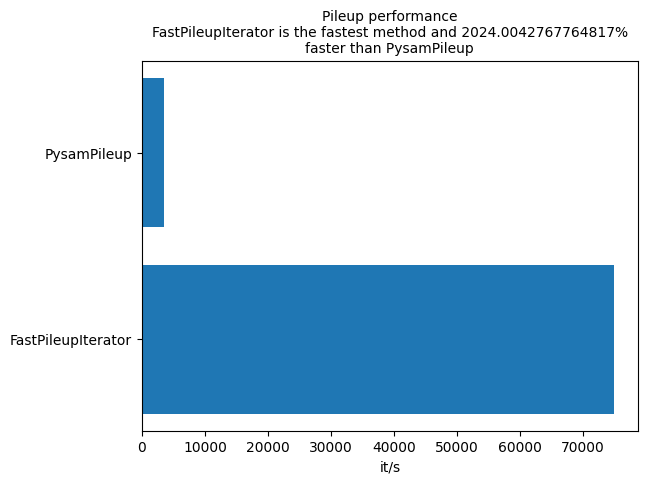

In [27]:
reg=gi('1',22377202,22429853) # the iterated region
times=defaultdict(Counter) 
# Counter for storing the results. Will contain one GI entry per position which is itself an {allele:count} Counter.
with pg.Timer(times, 'FastPileupIterator') as timer:
    ac1=Counter()
    with pg.open_file_obj(pg.get_resource('small_example_bam')) as bam:
        for l,v in tqdm(pg.FastPileupIterator(bam, reg.chromosome, range(reg.start, reg.end))):
            ac1[l.chromosome, l.start]=v
with pg.Timer(times, 'PysamPileup') as timer:
    ac2=Counter()
    with pg.open_file_obj(pg.get_resource('small_example_bam')) as bam:
        for pu in tqdm(bam.pileup(contig=reg.chromosome, start=reg.start-1, stop=reg.end-1, 
                                  flag_filter=pg.DEFAULT_FLAG_FILTER, truncate=True, mark_ends=True,
                                  add_indels=True, min_base_quality=0, min_mapping_quality=0,
                                  ignore_overlaps=False, ignore_orphans=False, max_depth=100000)):
            pos=(pu.reference_name, pu.reference_pos+1)
            ac2[pos]=Counter()
            for r in pu.pileups:
                if r.is_refskip:
                    continue
                elif r.is_del:
                    ac2[pos][None]+=1
                else:
                    ac2[pos][r.alignment.query_sequence[r.query_position]]+=1

# PysamPileup will not iterate/report uncovered alignment columns. So, here we add empty Counters for those positions
for p in (ac1.keys() - ac2.keys()):
    ac2[p]=Counter()
          
# now compare the resulting counters
assert ac1==ac2

# plot the times
pg.plot_times('Pileup performance', times, n=len(reg), reference_method='FastPileupIterator')

# show some example columns
pg.head_counter(ac1)

### AnnotationIterator

Data integration is a central use case for genomic libraries which often requires the annotation of genomic intervals with data derived from other, overlapping genomic intervals. One example is to calculate a score baed on data associated with all overlapping intervals from one or multiple other dataset(s).

There are many different approaches to achieve these tasks:
- in [pybedtools](https://daler.github.io/pybedtools), which is based on BEDTools, you could:
    - [intersect](https://daler.github.io/pybedtools/autodocs/pybedtools.bedtool.BedTool.intersect.html#pybedtools.bedtool.BedTool.intersect) the respective interval sets
    - apply a custom annotation method via [map()](https://daler.github.io/pybedtools/autodocs/pybedtools.bedtool.BedTool.map.html#pybedtools.bedtool.BedTool.map) or [each()](https://daler.github.io/pybedtools/autodocs/pybedtools.bedtool.BedTool.each.html#pybedtools.bedtool.BedTool.each) method
- In [bioframe](https://bioframe.readthedocs.io/), which is based on pandas dataframes, you could:
    - first use [overlap()](https://bioframe.readthedocs.io/en/latest/guide-intervalops.html#overlap) to intersect the interval sets
    - then group on the annotated feature location using pandas [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method
    - and finally apply some [user defined mutate methods](https://pandas.pydata.org/docs/user_guide/gotchas.html#gotchas-udf-mutation) via apply() or aggregate().

`pygenlib` contains an `AnnotationIterator` for annotating genomic intervals with data from one or *multiple* other genomic location iterators.
This iterator synchronizes genomic locations of the primary iterator (iterating the intervals to be annotated) with all annotating iterators and yields respective locations and data for all overlapping intervals. In the example below, we iterate over annotations in a genomic subregion of a flybase GTF file and annotate all features with  (i) a list of SNPs that were called in 3 particular samples of a multi-sample VCF file and (ii) values from bedgraph file.

**Note** that iterating over large interval sets is generally considered slow and is often not needed. 
In many cases you can use list [comprehension, vectorisation](https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-pandas-dataframe/)
or mechanisms such as [pandas apply()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) or [pybedtools each()](https://daler.github.io/pybedtools/each.html) as described above. 
Nevertheless, there are scenarios in which we consider AnnotationIterators  useful, e.g., if you need to access to contextual data (e.g., annotation results from previous data rows) or if you need (fine-grained) access to multiple synchronized datasets in parallel. Performance drawbacks of iteration approaches are also diminished when integrating multiple iterators in parallel. The overall goal of AnnotationIterators is to improve code readability and reduce potential error sources such as [the ones discussed in the 'RelatedWork' notebook](RelatedWork_performance.ipynb#Potential-pifalls). AnnotationIterators are also used by pygenlib's [`transcriptome.annotate()`](#Annotation-of-features) method for incremental transcriptome annotation as shown below.

In [2]:
# Annotate flybase GTF annotation with (i) a list of the genotypes of overlapping SNPs for 
# 3 samples and (ii) the maximum value from a bedgraph track
with pg.AnnotationIterator(
    pg.GFF3Iterator(pg.get_resource('flybase_gtf'), '2L', 1, 30000), # iterate over 2L:1-30000 in the flybase GTF
    [pg.VcfIterator(pg.get_resource('dmel_multisample_vcf'), # annotate with overlapping SNPs but consider 3 samples only
                    samples=['DGRP-208', 'DGRP-325', 'DGRP-721']),
     pg.BedGraphIterator(pg.get_resource('dmel_randomvalues'))], # annotate with 
    disable_progressbar=True) as it:
    for loc, (gff_feature, overlapping_snps, rand_values) in it.to_list()[:5]: # here we show just the first 5 features...
        # Remember that pygenlib iterators return named (location, data) tuples. Here, 'snps' is a list of such 
        # items and we can access the respective VCFRecord objects via the data field:
        overlapping_snps=[x.data for x in overlapping_snps]
        # rand_values is a sorted list (by genomic location) of overlapping values from the Bedgraph file.
        # We use min/max to get the first/last items from this list and access the value via the 
        # data field and convert from float (as returned by the bedgraph iterator) to int:        
        tp_value, fp_value = int(min(rand_values).data), int(max(rand_values).data) 
        # now we can display some data
        display(f"{gff_feature['feature_type']}@{loc} {gff_feature.get('transcript_id','NA')} (gene {gff_feature['gene_symbol']})")
        display(f"SNPs: {overlapping_snps}")
        display(f"3'-value: {tp_value}, 5'-value: {fp_value}", SEP)

'gene@2L:7529-9484 (+) NA (gene CR11023)'

'SNPs: [2L:7556T>C, 2L:7902A>G, 2L:8124A>C, 2L:8263G>A, 2L:9204T>C]'

"3'-value: 870, 5'-value: 319"

---

'pseudogene@2L:7529-9484 (+) FBtr0475186 (gene CR11023)'

'SNPs: [2L:7556T>C, 2L:7902A>G, 2L:8124A>C, 2L:8263G>A, 2L:9204T>C]'

"3'-value: 870, 5'-value: 319"

---

'exon@2L:7529-8116 (+) FBtr0475186 (gene CR11023)'

'SNPs: [2L:7556T>C, 2L:7902A>G]'

"3'-value: 870, 5'-value: 146"

---

'exon@2L:8193-9484 (+) FBtr0475186 (gene CR11023)'

'SNPs: [2L:8263G>A, 2L:9204T>C]'

"3'-value: 622, 5'-value: 319"

---

'exon@2L:9839-11344 (-) FBtr0078171 (gene l(2)gl)'

'SNPs: [2L:10018G>A, 2L:10089G>A, 2L:10610G>T]'

"3'-value: 932, 5'-value: 856"

---

#### Genomic interval arithmetic
Here is another example in which we simply annotate intervals from a BED file with the sum of scores or all overlapping intervals from a bedgraph file.
As all pygenlib `LocationIterators` yield their current genomic interval in a uniform format, it is straightforward to use interval arithmetic in the annotation method (in this example we calculate the overlap fraction to calculate the actual score contributions of overlapping bedgraph intervals).

In [13]:
# Annotate all intervals in a BED file with sum of scores from a bedgraph file; supports bedgraph intervals >1bp: 
# score contribution is calculated from the interval overlap (this bedgraph file contains, e.g., an interval (1:7-10, 0.3))
print('pygenlib annotation iterator wrapping a Bed- and a BedGraphiterator')
with pg.AnnotationIterator(pg.BedIterator(pg.get_resource('test_bed')), 
                           pg.BedGraphIterator(pg.get_resource('test_bedgraph')), 
                           labels=['scores'], disable_progressbar=True) as it:
    for loc, i in it:
        display(f"Annotation {i.anno}, sum:{sum([x.data*loc.overlap(x.location) for x in i.scores])}")
    display(it.stats())
display(SEP)
    
    
# Same as above, just for demonstration purposes, but now using pybedtools iterators that wrap a pybedtools BedTool
print('pygenlib annotation iterator wrapping two PybedtoolsIterators')
with pg.AnnotationIterator(pg.PybedtoolsIterator(pg.get_resource('test_bed')), 
                           pg.PybedtoolsIterator(pg.get_resource('test_bedgraph')), 
                           labels=['scores'], disable_progressbar=True) as it:
    for loc, i in it:
        # Note the slight differences. The returned data is now a pybedtools item, access to the 
        # bedgraph score is via the name attribute (but its a string, so we need to convert to float). 
        display(f"Annotation {i.anno}, sum:{sum([float(x.data.name)*loc.overlap(x.location) for x in i.scores])}")
    display(it.stats())

pygenlib annotation iterator wrapping a Bed- and a BedGraphiterator


'Annotation 1:6-10 (int1), sum:1.408'

'Annotation 1:10-15 (int2), sum:0.3'

'Annotation 2:10-150 (int3), sum:0'

Counter({('yielded_items', '1'): 2, ('yielded_items', '2'): 1})

---

pygenlib annotation iterator wrapping two PybedtoolsIterators


'Annotation 1\t5\t10\tint1\n, sum:1.408'

'Annotation 1\t9\t15\tint2\n, sum:0.3'

'Annotation 2\t9\t150\tint3\n, sum:0'

Counter({('yielded_items', '1'): 2, ('yielded_items', '2'): 1})

### TiledIterator for splitting large datasets
A common practice of many genomics applications is to break up analyses into continuous blocks (genomic intervals or tiles), e.g., to parallelize computation or just to deal with large datasets. Splitting a reference dict (i.e., a genome representation) into such blocks can easily be done using its `iter_blocks()` method. Iterating over a large BAM file, handling non-overlapping genomic intervals, for example, can be done as shown below.

*Note that you could also use an AnnotationIterator for this task as demonstrated above. In this case the region list must be sorted though!*

In [14]:
# Create a read iterator and add a 'chr' prefix to the chromosome names (via fun_alias)
with pg.ReadIterator(pg.get_resource('small_example_bam'), flag_filter=0, fun_alias=pg.toggle_chr) as it: 
    # Iterate the alignments and count the number of reads per tile.
    with pg.TiledIterator(it, tile_size=int(1e8)) as tit: 
        # Store the results in a dict, but ony for 'canonical' GRCh38 chromosomes
        stats={loc: len(dat) for loc, dat in tit if loc.chromosome in pg.CANONICAL_CHROMOSOMES['GRCh38']}
# show first 10 entries of the results dict. There are reads only at the beginning of chromosome 1 in this file.
display(dict(list(stats.items())[0:10]), '...')

{chr1:1-100000000: 31678,
 chr1:100000001-200000000: 0,
 chr1:200000001-249250621: 0,
 chr2:1-100000000: 0,
 chr2:100000001-200000000: 0,
 chr2:200000001-243199373: 0,
 chr3:1-100000000: 0,
 chr3:100000001-198022430: 0,
 chr4:1-100000000: 0,
 chr4:100000001-191154276: 0}

'...'

Here is another example in which we bin data from a begraph file by tiling it into blocks and iterating the respective scores and the locations of the intervals they stem from. 

In [15]:
# show the 'raw' data as a dataframe
display(pg.BedGraphIterator(pg.get_resource('test_bedgraph')).to_dataframe())
# Create a bedgraph iterator. As we cannot retrieve chromosome lengths from tabix files, 
# we set `calc_chromlen=True` to estimate them from iterating the file. We can then 
# calculate tiles that cover all covered regions. 
with pg.BedGraphIterator(pg.get_resource('test_bedgraph'), calc_chromlen=True) as it:
    # Create a list of non-overlapping intervals (tiles) of size 7 from the iterator's refdict.
    regions = it.refdict.iter_blocks(block_size=7)
    # Iterate the alignments and display the tile interval, the data from the bedgraph file, the respective interval locations and a weighted sum
    with pg.TiledIterator(it, regions) as tit:
        for loc, dat in tit:
            display(f"{loc}: scores: {dat} locations: {tit.tile_locations}, sum: {sum([x*loc.overlap(y) for x,y in zip(dat, tit.tile_locations)])}")

,Chromosome,Start,End,Strand,Value
0,1,1,1,.,0.0
1,1,2,2,.,0.042
2,1,3,3,.,0.083
3,1,4,4,.,0.125
4,1,5,5,.,0.167
5,1,6,6,.,0.208
6,1,7,10,.,0.3
7,1,16,17,.,0.7
8,1,18,19,.,0.8
9,1,21,40,.,0.1


'1:1-7: scores: (0.0, 0.042, 0.083, 0.125, 0.167, 0.208, 0.3) locations: (1:1-1, 1:2-2, 1:3-3, 1:4-4, 1:5-5, 1:6-6, 1:7-10), sum: 0.925'

'1:8-14: scores: (0.3,) locations: (1:7-10,), sum: 0.8999999999999999'

'1:15-21: scores: (0.7, 0.8, 0.1) locations: (1:16-17, 1:18-19, 1:21-40), sum: 3.1'

'1:22-28: scores: (0.1,) locations: (1:21-40,), sum: 0.7000000000000001'

'1:29-35: scores: (0.1,) locations: (1:21-40,), sum: 0.7000000000000001'

'1:36-40: scores: (0.1,) locations: (1:21-40,), sum: 0.5'

## Transcriptome implementation
_Pygenlib_ provides a `transcriptome` implementation that enables convenient access/filtering of genomic annotations via python. 
Briefly, a (filtered) input GTF/GFF file is parsed and respective (frozen) dataclasses that derive from the generic `Feature` class are instantiated. 
The implementation keeps track of parent/child relationships (e.g., between genes, transcripts and their exons) and enables efficient iteration/querying and annotation of genomic annotations. Data fields and annotations can conveniently be accessed via 'dot' notation (i.e., `<feature>.<attribute>`). 

Note that the current implementation does not implement the full GFF3 format as specified [here](https://github.com/The-Sequence-Ontology/Specifications/blob/master/gff3.md)
but currently rather supports various popular gff 'flavours' as published by encode, ensembl, ucsc, chess, mirgenedb and flybase.
It also supports a 'generic' GFF3 format where all parsed features are interpreted as 'transcript' objects irrespecting the actual feature_type column.
Respective parent 'gene' annotations are automatically added, no sub-features (exons, introns, etc.) are created.

Here is a brief description of the datamodel depicted below:
-   Model contains `genes`, `transcripts` and arbitrary sub-features (e.g., `exons`, `introns`, 3'/5'-`UTR`s, `CDS`) as defined
    in the GFF file. Note that `intron` annotations are calculated automatically from exon annotations unless configured otherwise. 
    Frozen dataclasses (derived from the 'Feature' class) are created for all parsed feature types automatically and users may configure which 
    GTF/GFF attributes will be parsed and added to those dataclasses as fields.
    Gene intervals must envelop transcript intervals which must envelop sub-feature intervals.
    
-   A transcriptome maintains an `anno` dict that maps (frozen) features to dicts of arbitrary annotation values which supports the (incremental) annotation of annotation features. Annotation values can be accessed like GFF-parsed fields via 'dot' notation: `<feature>.<attribute>`. 
    
-   The implementation exploits the hierarchical relationship between genes and their sub-features to optimize storage and computational requirements where possible.        
    Genomic sequences, for example, can be loaded from a reference genome via load_sequence_datas() but will only be directly stored in strings attached to gene feature.
    Sequences can then be accessed via transcriptome.get_sequence(). For sub-features (e.g., transcripts, exons, etc.) the respective sequence will be sliced from the 
    gene sequence on demand.  Note that despite being computed on demand, genomic sequences can still be accessed via `<feature>.sequence` which will call 
    transcriptome.get_sequence() with default parameters.
    
-   The get_sequence() method supports several modes:
    If `mode='rna'` is passed, the sequence is returned in 5'-3' orientation, i.e., they are reverse-complemented
    for minus-strand transcripts. The returned sequence will, however, still use the DNA alphabet (ACTG) to
    enable direct alignment/comparison with genomic sequences.
    if `mode='spliced'`, the spliced 5'-3' sequence will be returned.
    if `mode='translated'`, the spliced 5'-3' CDS sequence will be returned.
    
-   Genomic range queries via query() are supported by a combination of interval and linear search queries.
    A transcriptome object maintains one intervaltree per chromosome built from gene annotations.
    Overlap/envelop queries will first be applied to the respective intervaltree and the (typically small
    result sets) will then be filtered, e.g., for requested sub-feature types.
    
-   Transcriptome models can also be built from subsets of GFF/GTF files by filtering contained transcripts with a TranscriptFilter() that can restrict, e.g., included chromosomes, genomic regions, transcript_ids, gene_types or transcripts with certain 'tag' values (as used in gencode).

-   A transcriptome object keeps track of the numbers of filtered GFF entries in a `log` Counter object that is, e.g., useful for debugging. The 'structure' of the parsed features can be accessed via the `get_struct()` method.

The following cells demonstrate some use cases.

![transcriptome datamodel](../docs/_static/pygenlib_transcriptome.png "Transcriptome datamodel")

### Basic access examples

In [40]:
# First, let's create a transcriptome containing dmel chromosome 2L annotation from a flybase annotation file.
t = pg.Transcriptome(
        genome_fa=pg.get_resource('dmel_genome'),      # genome FASTA
        annotation_gff=pg.get_resource('flybase_gtf'), # Gene annotation GTF/GFF file
        annotation_flavour='flybase',               # flavour of the annotation file.
        load_sequence_data=True, # load sequences from configured genome FASTA file
        disable_progressbar=True, # no progressbars,
        feature_filter={'location': { 'included': { 'chromosomes': ['2L'] } }} # a simple filter that will include only annotations from 2L
    ) 
# show some stats/debugging information
display(t) # show some basic info (#genes, #tx)
display(t.get_struct()) # Show the hierarchical structure encoded in the GFF
display(t.log) # show stats (such as parsed and filtered lines)

Transcriptome with 14 genes and 41 tx (+seq)

{'gene': {'transcript'},
 'transcript': {'CDS',
  'exon',
  'five_prime_UTR',
  'gene',
  'intron',
  'three_prime_UTR',
  'transcript'},
 'exon': set(),
 'intron': set(),
 'five_prime_UTR': set(),
 'three_prime_UTR': set(),
 'CDS': set()}

Counter({'parsed_gff_lines': 749})

In [41]:
# Now, we can access some data:                              
# show gene names that were parsed from the flybase 'gene_symbol' field
display(f"Gene names: {[g.gene_name for g in t.genes]}",SEP) 
# query gene by name and get its transcripts
display(f"Transcripts of gene 'l(2)gl': {[tx.feature_id for tx in t.gene['l(2)gl'].transcript]}.",SEP) 
# get number of exons per transcripts
display(f"Number of exons per Cda5 tx: { {tx.feature_id:len(tx.exon) for tx in t.gene['Cda5'].transcript} }",SEP) 
# Access transcript by id and show the name field of its gene (=parent)
display(f"The parent gene of transcript 'FBtr0330655' is {t.transcript['FBtr0330655'].parent.gene_name}",SEP) 

"Gene names: ['CR11023', 'l(2)gl', 'Ir21a', 'asRNA:CR43609', 'Cda5', 'lncRNA:CR46254', 'lncRNA:CR45339', 'lncRNA:CR45340', 'dbr', 'asRNA:CR44987', 'galectin', 'CG11374', 'net', 'Zir']"

---

"Transcripts of gene 'l(2)gl': ['FBtr0306591', 'FBtr0078169', 'FBtr0078168', 'FBtr0078170', 'FBtr0306592', 'FBtr0306590', 'FBtr0078167', 'FBtr0330655', 'FBtr0078171', 'FBtr0078166', 'FBtr0306589']."

---

"Number of exons per Cda5 tx: {'FBtr0309227': 12, 'FBtr0309228': 14, 'FBtr0309226': 14, 'FBtr0309229': 15, 'FBtr0078163': 13, 'FBtr0078164': 14, 'FBtr0113416': 13, 'FBtr0309225': 11}"

---

"The parent gene of transcript 'FBtr0330655' is l(2)gl"

---

In [42]:
# Some more access examples
# genes can be accessed by name or gene id; their location
display(f"The gene {t.gene['l(2)gl'].gene_name} is located on chromosome {t.gene['l(2)gl'].location.chromosome} at {t.gene['FBgn0002121'].location} ", SEP) 

# you can inspect the fields of a transcriptome feature with regular python methods, e.g. vars()
# Here we show, e.g., the structure of the 1st transcript
tx = t.gene['l(2)gl'].transcript[0]
display_textarea(pprint.pformat(vars(tx)))

# fields as well as dynamic annotations (see below) can be accessed by <feature>.<attribute/field> notation
# this includes calculated annotations such as location and rnk (exon/intron number)
display(f"transcript_id: {tx.feature_id}, location: {tx.location}, 1st exon rnk: {tx.exon[0].rnk}")

'The gene l(2)gl is located on chromosome 2L at 2L:9839-21376 (-) '

---

'transcript_id: FBtr0306591, location: 2L:9839-21376 (-), 1st exon rnk: 1'

### Sequence access

In [43]:
# Genomic sequences are another example for dynamically calculated annotations. 
# They must first be loaded for each gene annotation with load_sequence_datas() 
# which is done automatically if 'load_sequence_datas': True is configured.
# They can be accessed by the t.get_sequence() method or by <feature>.sequence which calls 
# get_sequence() with default params.
# We demonstrate this by accessing some data of a transcript of the 'l(2)gl (FBgn0002121)' gene
rand_tx = random.sample(t.gene['l(2)gl'].transcript,1)[0]
display(f"Selected tx: {rand_tx.feature_id}")
display_textarea(f"DNA sequence of 1st exon: {rand_tx.exon[0].sequence}")
display_textarea(f"Spliced sequence: {rand_tx.spliced_sequence}")

# SJs can be displayed by calling get_sequence(mode='spliced', show_exon_boundaries=True)
display_textarea(f"Spliced sequence showing SJ ('*'): {t.get_sequence(rand_tx, mode='spliced', show_exon_boundaries=True)}")

# sequences will be reverse complemented for - strand transcripts if mode='rna'
# get some random minustrand tx
tx=random.sample([tx for tx in t.transcripts if tx.strand=='-'], 1)[0]

# show sequence of 1st exon in dna and rna mode (reverse complement as the gene is on the - strand)
display(f"tx {tx.feature_id}, exon 1: dnaseq={t.get_sequence(tx.exon[0], mode='dna')}, rnaseq={t.get_sequence(tx.exon[0], mode='rna')}", SEP)

'Selected tx: FBtr0078167'

'tx FBtr0290323, exon 1: dnaseq=CTTTCATAATAATTGCTGATAATTCCGATGCGCTTAGTTGCATGTAAAGTTTTTCTGTGTTGGTATTCGCCATAGCCGCGAAGGACATTCAAGAACTTTAAAAGTAGCGCGTATCCGAAAACGGTATTTGAATAGTTTTGTGGGCTTATATTTTATTTATTCACAATTACGGGCTTTATGTTAACATAAACCTATTGAAATGTCACGTATTGTTTAAAGGCACTTTTTTAATTTGTGGTTTGGTTAAGCCGTATGTGAGCTTTGGCACTATCTTCAACTTATTAGAACTTTTTATTTTCACGATTTCTCGTAAAATCTTCTGACCGGAGCACGACTGTTCACAACGAAAGTATCTGACGGATTGAAAA, rnaseq=TTTTCAATCCGTCAGATACTTTCGTTGTGAACAGTCGTGCTCCGGTCAGAAGATTTTACGAGAAATCGTGAAAATAAAAAGTTCTAATAAGTTGAAGATAGTGCCAAAGCTCACATACGGCTTAACCAAACCACAAATTAAAAAAGTGCCTTTAAACAATACGTGACATTTCAATAGGTTTATGTTAACATAAAGCCCGTAATTGTGAATAAATAAAATATAAGCCCACAAAACTATTCAAATACCGTTTTCGGATACGCGCTACTTTTAAAGTTCTTGAATGTCCTTCGCGGCTATGGCGAATACCAACACAGAAAAACTTTACATGCAACTAAGCGCATCGGAATTATCAGCAATTATTATGAAAG'

---

In [44]:
# The transcriptome implementation also supports (annotated) CDS annotations. Users can directly access the translated sequence:
display_textarea(f"Translated sequence of FBtr0330655: {t.transcript['FBtr0330655'].translated_sequence}")

# align spliced (including 5'/3' UTRs) and translated sequence using biopython
display_textarea(next(PairwiseAligner(mode='global', open_gap_score=-3).align(
        t.transcript['FBtr0330655'].translated_sequence, 
        t.transcript['FBtr0330655'].spliced_sequence)))
    
# translate with biotite
display_textarea(f"Amino acid sequence of FBtr0078164: {seq.NucleotideSequence(t.transcript['FBtr0330655'].translated_sequence).translate(complete=True)}")

Exact kmer search in sequences can be performed by standard python methods

In [45]:
# list all gene names where the kmer is found in one of the (spliced) transcripts
display(f"Genes containing ATGC kmer in one of their (spliced) tx: { { tx.parent.gene_name for tx in t.transcripts if 'ATGC' in tx.spliced_sequence }}", SEP)

# list all gene names where the kmer is found in one of its transcripts introns considering only long (>1kb) introns
display(f"Genes containing ATGC kmer in a long (>1kb) intron: { { tx.parent.gene_name for tx in t.transcripts for intron in tx.intron if len(intron)>1000 and 'ATGC' in intron.sequence}}", SEP)

"Genes containing ATGC kmer in one of their (spliced) tx: {'Ir21a', 'l(2)gl', 'CR11023', 'lncRNA:CR46254', 'lncRNA:CR45339', 'dbr', 'asRNA:CR44987', 'net', 'galectin', 'asRNA:CR43609', 'CG11374', 'lncRNA:CR45340', 'Zir', 'Cda5'}"

---

"Genes containing ATGC kmer in a long (>1kb) intron: {'net', 'galectin', 'l(2)gl', 'Cda5'}"

---

### Querying
Transcriptome features can be effieciently queried via python list comprehension or 
via interval-tree based range queries.
    
In the following example, we demonstrate both approaches:

In [46]:
# find all minus strand genes with transcripts that have >=2 exons and at least one long (>1kb) intron via list comprehension
{tx.parent.gene_name for tx in t.transcripts if tx.strand=='-' and len(tx.exon)>=2 and any([len(i)>1000 for i in tx.intron])}

{'Cda5', 'l(2)gl', 'net'}

#### Range queries

Efficient range queries are implemented by prefiltering the data using per-chromosome [intervaltrees](https://github.com/chaimleib/intervaltree). The respective interval trees are built automatically by
the transcriptome class and can be queried via the `query()` method which is demonstrated below.


In [47]:
# Efficient range queries are implemented by intervaltrees:
display(f"Genes where an exon overlaps with 2L:10000-20000: { {ex.parent.parent.gene_name for ex in t.query(gi.from_str('2L:10000-20000'), 'exon')}}", SEP) 

# Query all transcripts that overlap with the 'l(2)gl' gene and create a set with their gene names.
l2gl=t.gene['l(2)gl'] # note that each transcriptome feature is also a genomic interval and can be queried
display(f"Genes of all transcripts that overlap with gene 'l(2)gl': {set(tx.parent.gene_name for tx in t.query(l2gl, 'transcript'))}", SEP) 

# report a coordinate-sorted list of genes in a 10kb window around cold:
display(f"Genes near 'l(2)gl': { [g.gene_name for g in t.query(gi(l2gl.chromosome, l2gl.start-3000, l2gl.end+3000), 'gene')]}", SEP)

# envelop queries are also supported:
display(f"Genes contained in a +/- 10kb window around 'l(2)gl': { [g.gene_name for g in t.query(gi(l2gl.chromosome, l2gl.start-3000, l2gl.end+3000), 'gene', envelop=True)]}", SEP)

# Direct access to the interval trees is possible via the chr2itree attribute. Here, we query intervals
# at position 2L:20000. The respective gene object can be accessed via the data slot.
display(f"Genes at 2L:20000: {[x.data.feature_id for x in t.chr2itree['2L'].at(20000)]}")

"Genes where an exon overlaps with 2L:10000-20000: {'l(2)gl'}"

---

"Genes of all transcripts that overlap with gene 'l(2)gl': {'l(2)gl'}"

---

"Genes near 'l(2)gl': ['CR11023', 'l(2)gl', 'Ir21a', 'asRNA:CR43609']"

---

"Genes contained in a +/- 10kb window around 'l(2)gl': ['CR11023', 'l(2)gl', 'asRNA:CR43609']"

---

"Genes at 2L:20000: ['FBgn0002121']"

#### Accessing up/downstream genes
The gene_triples() method yields genes and their neighbouring (up-/downstream) within a given maximum distance:

In [48]:
# iterate genes and their up/downstream genes within a given max distance. Show only first 10 entries.
def get_name(x):
    return None if x is None else x.gene_name
display([(get_name(x),get_name(y),get_name(z)) for x, y, z in t.gene_triples(max_dist=10000)][:10])

# Note that the distance between lncRNA:CR46254 and lncRNA:CR45339 is > 10kb
display(f"Distance between lncRNA:CR46254 and lncRNA:CR45339: {t.gene['lncRNA:CR46254'].distance(t.gene['lncRNA:CR45339'])}")

[(None, 'CR11023', 'l(2)gl'),
 ('CR11023', 'l(2)gl', 'Ir21a'),
 ('l(2)gl', 'Ir21a', 'asRNA:CR43609'),
 ('Ir21a', 'asRNA:CR43609', 'Cda5'),
 ('asRNA:CR43609', 'Cda5', 'lncRNA:CR46254'),
 ('Cda5', 'lncRNA:CR46254', None),
 (None, 'lncRNA:CR45339', 'lncRNA:CR45340'),
 ('lncRNA:CR45339', 'lncRNA:CR45340', 'dbr'),
 ('lncRNA:CR45340', 'dbr', 'asRNA:CR44987'),
 ('dbr', 'asRNA:CR44987', 'galectin')]

'Distance between lncRNA:CR46254 and lncRNA:CR45339: 10232'

#### Accessing 3'-ends
The calc_3end() method returns a list of genomic interval(s) containing the last <width> bases
of a passed transcript.

In [49]:
# Create a dict of genes and their unique 1000bp 3'UTR intervals per tx (multiple intervals if spliced); 
# note that for, e.g., Ir21a/FBtr0113008 2 intervals are reported as the 1000bp UTR overlaps a splice junction
display({g.gene_name: {tx.feature_id:pg.calc_3end(tx, width=1000) for tx in g.transcript} for g in t.genes})

{'CR11023': {'FBtr0475186': [2L:8485-9484 (+)]},
 'l(2)gl': {'FBtr0306591': [2L:9839-10838 (-)],
  'FBtr0078169': [2L:9839-10838 (-)],
  'FBtr0078168': [2L:9839-10838 (-)],
  'FBtr0078170': [2L:9839-10838 (-)],
  'FBtr0306592': [2L:9839-10838 (-)],
  'FBtr0306590': [2L:9839-10838 (-)],
  'FBtr0078167': [2L:9839-10838 (-)],
  'FBtr0330655': [2L:9839-10838 (-)],
  'FBtr0078171': [2L:9839-10838 (-)],
  'FBtr0078166': [2L:9839-10838 (-)],
  'FBtr0306589': [2L:9839-10838 (-)]},
 'Ir21a': {'FBtr0113008': [2L:21823-22687 (-), 2L:22743-22877 (-)]},
 'asRNA:CR43609': {'FBtr0309810': [2L:23238-24237 (+)]},
 'Cda5': {'FBtr0309227': [2L:25402-26401 (-)],
  'FBtr0309228': [2L:25402-26401 (-)],
  'FBtr0309226': [2L:25402-26401 (-)],
  'FBtr0309229': [2L:25402-26401 (-)],
  'FBtr0078163': [2L:25402-26401 (-)],
  'FBtr0078164': [2L:25402-26401 (-)],
  'FBtr0113416': [2L:25402-26401 (-)],
  'FBtr0309225': [2L:25402-26401 (-)]},
 'lncRNA:CR46254': {'FBtr0347585': None},
 'lncRNA:CR45339': {'FBtr0345732'

#### Accessing up-/downstream windows
Here we iterate all transcripts and calculate a downstream (3') genomic window and its dna sequence. 
For demonstration purposes, we show only the first three 3'-end bases.
(NOTE: For adding 5'-end windows, just use 'upstream' as window_type)

In [50]:
window_type='downstream'
ws=3
# NOTE that if you use a sliced genome sequence, you have to correct coordinates using the respective 'genome_offsets' 
# values. We have added the respective code here although this example works with a full dmel genome sequence.
with pysam.Fastafile(t.genome_fa) as fasta:
    for tx in tqdm(t.transcripts, desc=f'Load {window_type} window sequences', total=len(t.transcripts)):
        strand = tx.strand
        assert strand is not None, f"Undefined strand for tx {tx}"
        loc = tx.get_upstream(ws) if window_type == 'upstream' else tx.get_downstream(ws)  # get up/downstream windows of given size
        dna_seq=''
        s = loc.start - t.genome_offsets.get(loc.chromosome, 1) 
        if s<0: # Pad with N's if required
            dna_seq='N'*(-s)
            s=0
        e = loc.end - t.genome_offsets.get(loc.chromosome, 1) + 1
        dna_seq+=fasta.fetch(reference=loc.chromosome,start=s,end=e) # get sequence from FASTA
        display(f"{window_type}: {tx.parent.gene_name},{tx.feature_id}, {loc}, {dna_seq}")

Load downstream window sequences:   0%|          | 0/41 [00:00<?, ?it/s]

'downstream: CR11023,FBtr0475186, 2L:9485-9487 (+), AAA'

'downstream: l(2)gl,FBtr0078170, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0078171, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0306591, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0078169, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0078168, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0306592, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0306590, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0078167, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0330655, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0078166, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0306589, 2L:9836-9838 (-), TTT'

'downstream: Ir21a,FBtr0113008, 2L:21820-21822 (-), TGT'

'downstream: asRNA:CR43609,FBtr0309810, 2L:24238-24240 (+), ACC'

'downstream: Cda5,FBtr0309227, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0309228, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0309229, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0078163, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0078164, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0113416, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0309225, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0309226, 2L:25399-25401 (-), ATT'

'downstream: lncRNA:CR46254,FBtr0347585, 2L:55768-55770 (+), AAA'

'downstream: lncRNA:CR45339,FBtr0345732, 2L:66243-66245 (+), TAC'

'downstream: lncRNA:CR45340,FBtr0345733, 2L:66525-66527 (+), CAA'

'downstream: dbr,FBtr0306539, 2L:71391-71393 (+), AAC'

'downstream: dbr,FBtr0306536, 2L:71082-71084 (+), AAT'

'downstream: dbr,FBtr0306538, 2L:71082-71084 (+), AAT'

'downstream: dbr,FBtr0306537, 2L:71391-71393 (+), AAC'

'downstream: dbr,FBtr0078100, 2L:71391-71393 (+), AAC'

'downstream: asRNA:CR44987,FBtr0344053, 2L:71036-71038 (-), TTT'

'downstream: asRNA:CR44987,FBtr0344052, 2L:71036-71038 (-), TTT'

'downstream: galectin,FBtr0306540, 2L:76212-76214 (+), ATT'

'downstream: galectin,FBtr0078101, 2L:76212-76214 (+), ATT'

'downstream: galectin,FBtr0302164, 2L:76212-76214 (+), ATT'

'downstream: galectin,FBtr0331680, 2L:76212-76214 (+), ATT'

'downstream: galectin,FBtr0301733, 2L:76212-76214 (+), ATT'

'downstream: CG11374,FBtr0306541, 2L:77784-77786 (+), AAT'

'downstream: net,FBtr0290323, 2L:82418-82420 (-), CCT'

'downstream: net,FBtr0330637, 2L:82981-82983 (-), ATT'

'downstream: Zir,FBtr0078103, 2L:102087-102089 (+), AAA'

### Feature Annotation

A transcriptome manages an `anno` dict that maps annotation features (e.g., an exon) to a dict containing arbitray annotations.
Annotations can be added manually or by using the `transcriptome.annotate()` method that implements a generic method to add feature-based annotations based on pygenlib's [`AnnotationIterator`](#AnnotationIterator). The following section demonstrates some use cases:

In [51]:
# First, let's instantiate a small transcriptome that contains only two human genes (ACTB and SOX2) 
t=pg.Transcriptome(
    genome_fa=pg.get_resource('ACTB+SOX2_genome'),  # reference genome FASTA
    genome_offsets= {'chr3': 181711825, 'chr7': 5526309}, # This is a sliced reference sequence. To match the gencode annotations we provide respective offset coordinates for the 2 chroms
    annotation_gff=pg.get_resource('gencode_gff'),  # gene annotation GFF
    annotation_flavour='gencode', # this is a gencode flavoured GFF
    load_sequence_data=True # load gene sequences from reference genome)
)
display(t)

Building transcriptome (2 chromosomes)
:   0%|          | 0/2 [00:00<?, ?it/s]

Load sequences:   0%|          | 0/5 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/5 [00:00<?, ?it/s]

Transcriptome with 5 genes and 89 tx (+seq)

  0%|          | 0/2 [00:00<?, ?it/s]

---

'Mappability for a random ACTB transcript:'

[(1, 'ENST00000645576.1_exon_4', 0.9730675675675676),
 (2, 'ENST00000645576.1_exon_3', 0.8161705426356585),
 (3, 'ENST00000645576.1_exon_2', 0.28020416666666664),
 (4, 'ENST00000645576.1_exon_1', 0.0),
 (5, 'ENST00000645576.1_exon_0', 0.0)]

---

'Some annotated values:'

'exon mappability value: 0.9702537313432836'

'gene mappability value: None'

---

'Dataframe representation'

,Chromosome,Start,End,Strand,feature_id,feature_type,mappability,gene_name,gene_type,gff_feature_type,source
119,chr7,5527784,5529570,-,ENST00000676319.1_intron_0,intron,0.373112,None,protein_coding,exon,HAVANA
203,chr7,5528281,5529059,-,ENST00000477812.2_exon_2,exon,0.432606,None,protein_coding,exon,HAVANA
204,chr7,5528281,5529400,-,ENST00000462494.5_exon_2,exon,0.451115,None,protein_coding,exon,HAVANA
206,chr7,5528672,5529160,-,ENST00000645576.1_intron_1,intron,0.895706,None,protein_coding,exon,HAVANA
207,chr7,5528708,5529149,-,ENST00000676189.1_intron_2,intron,0.966063,None,protein_coding,exon,HAVANA
...,...,...,...,...,...,...,...,...,...,...,...
369,chr7,5530524,5530604,-,ENST00000676319.1_exon_2,exon,0.975395,None,protein_coding,exon,HAVANA
371,chr7,5530524,5530604,-,ENST00000676189.1_exon_5,exon,0.975395,None,protein_coding,exon,HAVANA
373,chr7,5530524,5530604,-,ENST00000473257.3_exon_4,exon,0.975395,None,protein_coding,exon,HAVANA
375,chr7,5530524,5530627,-,ENST00000432588.6_exon_4,exon,0.980837,None,protein_coding,exon,HAVANA


---

<Axes: title={'center': 'mappability histogram'}, ylabel='Frequency'>

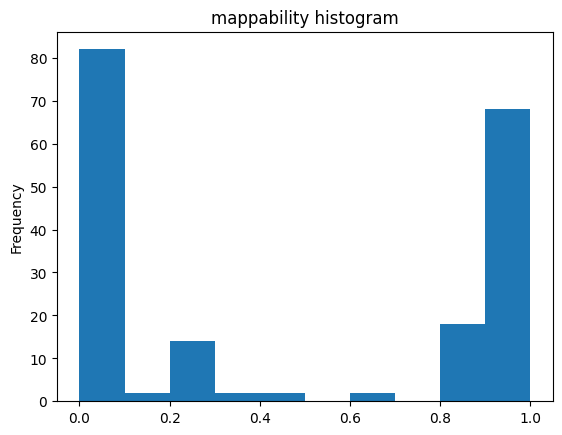

In [52]:
# Now, lets annotate exons and introns with mappability scores that are read from a bedgraph file.
# We first create a method for calculating the mean mappability for an annotation based on the scores of
# all overlapping intervals from the bedgraph file.
def calc_mean(item, label='mappability'):
    loc, (anno, scores) = item
    anno[label]=sum([score*loc.overlap(sloc) for sloc,score in scores])/len(loc)
    return calc_mean

# now we can call the annotate method, tell it to get the scores from a bedgraph iterator and
# to annotate only exons + introns. Note that this test bedgraph file covers only ~half of ACTB,
# (use a genome  browser like IGV to confirm this). So the mappability of the uncovered regions will 
# be set to zero.
t.annotate(iterators=pg.BedGraphIterator(pg.get_resource('human_umap_k24')),
           fun_anno=calc_mean,
           feature_types=['exon', 'intron'])

# Now, lets show the mappability values for exons and introns of one random transcript 
rnd_tx = random.sample(t.gene['ACTB'].transcript, 1)[0]
display(SEP, "Mappability for a random ACTB transcript:", [(f.rnk, f.feature_id, f.mappability) for f in rnd_tx.exon])
# Note that it would be more efficient to annotate genes with mappability score arrays and then calculate mean/median mappability
# for each feature by slicing these arrays (as done, e.g., for sequences) but this is omitted here for the sake of simplicity


# use get/getattr to provide sensible default values for missing data:
display(SEP, "Some annotated values:")
display(f"exon mappability value: {t.transcript['ENST00000477812.2'].exon[0].get('mappability',None)}") # show some mappability value
display(f"gene mappability value: {t.gene['ACTB'].get('mappability',None)}") # only exons/introns were annotated above
display_textarea(f"exon sequence: {t.transcript['ENST00000477812.2'].exon[0].get('sequence',None)}") # here, the sequence is sliced from the parent gene

# We can also convert results to a dataframe (but note that we lose the parent/child relationships here).
df = pg.TranscriptomeIterator(t).to_dataframe()
# let's use the pandas query method to show features from protein_coding genes with non-zero mappability...
display(SEP, "Dataframe representation", df.query('gene_type=="protein_coding" & mappability>0'),SEP)
# ...and plot the overall mappability distribution...
df['mappability'].plot(kind='hist', title='mappability histogram')

#### Example: Calculate number of overlapping features
In this example, we calculate the number of overlapping introns per exon.

  0%|          | 0/2 [00:00<?, ?it/s]

"Example exon@chr7:5529067-5529663 with 33 overlapping introns: {'ENST00000645025.1_intron_1', 'ENST00000642480.2_intron_2', 'ENST00000414620.1_intron_0', 'ENST00000425660.5_intron_4', 'ENST00000642480.2_intron_3', 'ENST00000425660.5_intron_3', 'ENST00000645576.1_intron_2', 'ENST00000473257.3_intron_2', 'ENST00000674681.1_intron_2', 'ENST00000676319.1_intron_0', 'ENST00000676189.1_intron_2', 'ENST00000493945.6_intron_2', 'ENST00000675515.1_intron_3', 'ENST00000484841.6_intron_2', 'ENST00000676189.1_intron_3', 'ENST00000473257.3_intron_3', 'ENST00000645576.1_intron_1', 'ENST00000432588.6_intron_2', 'ENST00000484841.6_intron_1', 'ENST00000493945.6_intron_3', 'ENST00000443528.5_intron_0', 'ENST00000646664.1_intron_2', 'ENST00000645025.1_intron_0', 'ENST00000674681.1_intron_3', 'ENST00000417101.2_intron_0', 'ENST00000477812.2_intron_2', 'ENST00000676397.1_intron_2', 'ENST00000462494.5_intron_2', 'ENST00000676397.1_intron_3', 'ENST00000646664.1_intron_3', 'ENST00000675515.1_intron_2', 'ENST

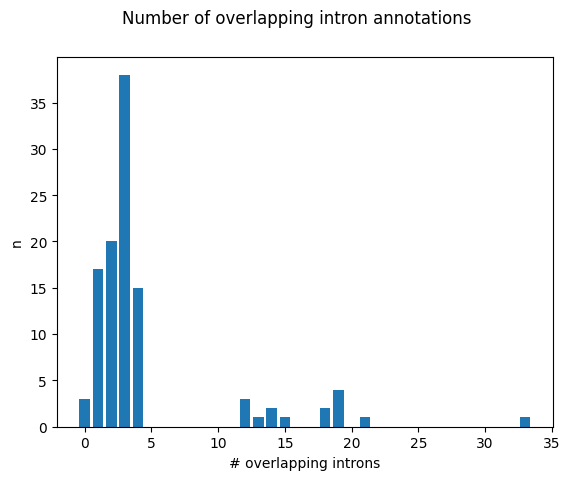

In [53]:
# Here we calculate the number of overlapping introns per exon.
def count_anno(item):
    loc, (anno, overlapping) = item
    # Here we simply count the number of overlapping intron annotations but we could also group
    # by tx or gene, etc.
    anno['n_overlapping_introns']=len(overlapping)
    anno['overlapping_introns']=overlapping

# now we can call the annotate method for all exons of this transcriptome and tell it to 
# annotate with all introns of this transcriptome. In the passed annotation method (count_anno) we 
# simply count the number of overlapping annotations (introns).
# Its easy to check in IGV (loading the GFF3 file) whether the numbers are correct.
t.clear_annotations() # make sure to remove previously added annotations
t.annotate(iterators=pg.TranscriptomeIterator(t,feature_types=['intron']),
           fun_anno=count_anno,
           feature_types=['exon'])

# Here we create a histogram ...
intron_hist=Counter()
for ex in pg.TranscriptomeIterator(t,feature_types=['exon']):
    intron_hist[ex.data['n_overlapping_introns']]+=1

# ... and plot it
x, y = zip(*intron_hist.items())
_=plt.bar(x,y)
plt.xlabel("# overlapping introns")
plt.ylabel("n")
_=plt.suptitle("Number of overlapping intron annotations")

# Here we show one example with max number of overlapping introns
# NOTE that there can be multiple introns per transcript that overlap with a given exon.
for ex,info in pg.TranscriptomeIterator(t,feature_types=['exon']):
    if info.get('n_overlapping_introns', 0)==max(intron_hist):
        tids = {i.parent.feature_id for i,_ in info['overlapping_introns']}
        display(f"Example {ex} with {info['n_overlapping_introns']} overlapping introns: { {i.feature_id for i,_ in info['overlapping_introns']} }, tids: {tids}")
        break    

### Conversion to a dataframe
Finally, we want to convert the data to a pandas dataframe containing all exons and include two custom colums, one containig the feature length and the other the gene name.

The to_dataframe() method supports the flexible construction of such dataframes (e.g., for further processing via bioframe, etc.) as demonstrated below:

In [30]:
# Convert to pandas dataframe with a custom conversion function
# Here we iterate only exons and custom data columns to the created dataframe:
# * it retrieves the 'gene_name' via the transcriptome model.
# * it calculates a 'feature length' from the exon interval
# * it converts the annotated 'overlapping_introns' list to a comma-separated string
# Finally, we add the new columns to the dataframe and drop some we do not need.
def my_fun(loc, item, fun_col, default_value): 
    return [loc.parent.parent.gene_name if col=='gene_name' else # get the gene_name from the grand-parent (=gene) feature \
            len(loc) if col=='feature_len' else # calc fature length \
            ','.join([str(x.location.feature_id) for x in loc.get(col, default_value)]) if col=='overlapping_introns' else # convert list of items to comma-separated string \
            loc.get(col, default_value) # get annotation from the feature directly \
            for col in fun_col]

df = t.iterator(feature_types='exon').to_dataframe( \
         fun=my_fun, # passes our annotation function
         included_columns=('feature_len',), # include our new column
         excluded_columns=('dna_seq', 'source', 'gff_feature_type') # columns that are dropped
        )

df.head(3)  # report max 3 items

,Chromosome,Start,End,Strand,feature_id,feature_type,n_overlapping_introns,overlapping_introns,gene_name,gene_type,feature_len
0,chr3,181711925,181714436,+,ENST00000325404.3_exon_0,exon,0,,SOX2,protein_coding,2512
1,chr7,5526409,5527891,-,ENST00000674681.1_exon_0,exon,3,"ENST00000464611.1_intron_0,ENST00000676319.1_i...",ACTB,protein_coding,1483
2,chr7,5527147,5527783,-,ENST00000676319.1_exon_0,exon,1,ENST00000464611.1_intron_0,ACTB,protein_coding,637


In [31]:
# We can also 'describe' a dataset which converts it to a pandas dataframe and calls describe
# Additionally it calculates some stats such as whether this dataset contains overlapping or empty intervals.
df, stats = pg.TranscriptomeIterator(t, feature_types='exon').describe(fun=my_fun)
display(df.head(5))
display(stats)

,Chromosome,Start,End,Strand,feature_id,feature_type,n_overlapping_introns,overlapping_introns,gene_name,gff_feature_type,source,gene_type
count,108,1.080000e+02,1.080000e+02,108,108,108,108.000000,108,108,108,108,108
unique,2,NaN,NaN,2,108,1,NaN,28,4,1,1,3
top,chr7,NaN,NaN,-,ENST00000325404.3_exon_0,exon,NaN,"ENST00000414620.1_intron_1,ENST00000443528.5_i...",ACTB,exon,HAVANA,protein_coding
freq,107,NaN,NaN,105,1,108,NaN,15,105,108,108,106
mean,NaN,7.162412e+06,7.162717e+06,NaN,NaN,NaN,4.527778,NaN,NaN,NaN,NaN,NaN


{'contains_overlapping': True, 'contains_empty': False}

In [32]:
# Here, for example, we iterate over the 1st 100 reads of a BAM file and get some summary statistics for the
# NM (number of mismatches) and NH (number of hits) tags
df, stats = pg.ReadIterator(pg.get_resource('small_example_bam')).describe(\
         fun=lambda loc, item, fun_col, default_value:[item.get_tag(col) for col in fun_col] , \
         fun_col=('NM', 'NH'), # include our new column
         max_items=100) # report max 100 items
display(df.head(5))
display(stats)

,Chromosome,Start,End,Strand,NM,NH
count,100,100.00,100.0,100,100.00,100.00
unique,1,NaN,NaN,2,NaN,NaN
top,1,NaN,NaN,+,NaN,NaN
freq,100,NaN,NaN,78,NaN,NaN
mean,NaN,22379157.79,22403099.2,NaN,0.66,1.02


{'contains_overlapping': True, 'contains_empty': False}

# Utility functions

_Pygenlib_ also contains a number of utility functions which might be useful for handling genomics data. Some of those functions were demonstrated already in the context of this notebook. Here we present and document them in more detail:

In [33]:
# Gene symbols are updated regularly and mapping between different id schemas is cumbersome
# pygenlib implements an interface to MyGeneInfo for easy translation between ids and symbols 
# Example: we pass a mixed list of Ensembl and Entrez ids for mouse and human  actin beta:
pg.geneid2symbol(['ENSMUSG00000029580', 60])

{'ENSMUSG00000029580': Actb (actin, beta, tax: 10090),
 '60': ACTB (actin beta, tax: 9606)}

In [34]:
# Another possibility is to use alias files that provide a mapping from previous (outdated) to current gene symbols.
# Pygenlib supports such alias files and here we showcase this by loading a small subset of genenames.org data 
# and using it to convert lists containing partially old gene symbols to their current symbol.
aliases, current_symbols = pg.read_alias_file(pg.get_resource('hgnc_gene_aliases'))
# now lets translate some gene symbols
display(pg.norm_gn('A2MP', current_symbols, aliases), 
        pg.norm_gn('FLJ23569', current_symbols, aliases),
        pg.norm_gn('A2MP1', current_symbols, aliases)) 
# Please note that the transcriptome implementation has implicit support for gene name aliasing, all you need to do is to pass a file path refering to a
# genenames.org like file via the 'gene_name_alias_file' config property.

load gene aliases:   0%|          | 0/9 [00:00<?, ?it/s]

'A2MP1'

'A1BG-AS1'

'A2MP1'

In [35]:
# And utilities to work with Nanopore data (FAST5 files)
# You can, e.g., inspect the structure of such a file:
fast5_file=pg.get_resource('nanoseq_fast5_raw')
pg.print_fast5_tree(fast5_file, show_attrs=False)

Raw └── Reads
Raw     └── Read_205344 {duration=21211,median_before=217.6046905517578,read_id=b'003c04de-f704-491e-8d0c-33ffa269423d',read_number=205344,start_mux=4,start_time=364905104}
Raw         └── Signal
---


In [36]:
# Or list the basecalling groups in this file
fast5_file=pg.get_resource('nanoseq_fast5_basecalled')#'testdata/fast5/FAT61995_a1291c8f_5.fast5'
pg.get_bcgs(fast5_file)

['Basecall_1D_000']

In [37]:
# the get_covered_contigs() method accesses a BAM index and quickly calculates which
# contigs contain reads:
pg.get_covered_contigs(pg.get_resource('small_example_bam'))

{'1'}

Please refer to the test_utils.py script for usage scenarios of other pygenlib utility methods.